In [1]:
%matplotlib inline
import pyspark as ps
import json
import datetime
import numpy as np
import pandas as pd
from pyspark.sql.types import *
from DataFrame import TweetsDataFrame
import matplotlib.pyplot as plt

plt.style.use('ggplot')


In [ ]:
spark = (ps.sql.SparkSession.builder 
        .master("local[4]") 
        .appName("sparkSQL exercise") 
        .getOrCreate())

sc = spark.sparkContext
        

In [3]:
df = TweetsDataFrame(spark, sc)

In [4]:
df.tweets.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- followers: integer (nullable = true)
 |-- verified: boolean (nullable = true)
 |-- text: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- retweets: integer (nullable = true)
 |-- favorites: integer (nullable = true)
 |-- lang: string (nullable = true)
 |-- place_type: string (nullable = true)
 |-- place_name: string (nullable = true)
 |-- place_full_name: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- country: string (nullable = true)



In [6]:
df.tweets.createOrReplaceTempView('tweets')

## Rafi

In [7]:
query = '''
        SELECT user_id, country_code, day, hour, place_name, text
        FROM tweets
        WHERE text LIKE '%macron%' OR text LIKE '%le pen%' 
        AND country_code = 'FR'
        
'''

result = spark.sql(query)
result.show()

+------------------+------------+---+----+--------------------+--------------------+
|           user_id|country_code|day|hour|          place_name|                text|
+------------------+------------+---+----+--------------------+--------------------+
|         273524713|          FR| 26|  13|    Gréoux-les-Bains|La macronie En Ma...|
|839403756768866304|          FR| 26|  13|            Toulouse|Choisir entre le ...|
|         472412133|          FR| 26|  13|Taisnières-en-Thi...|@ArtCoutelier ba ...|
|753617799671582720|          FR| 26|  13|          Genouillac|Sans déconner, ma...|
|         239165579|          FR| 26|  13|               Paris|@LeaFrct @Dormez_...|
|        3008275655|          FR| 26|  13|               Paris|@DELARUEEm @Miche...|
|         178877106|          FR| 26|  14|              Rennes|ptdr j'ai unfollo...|
|        3291475995|          FR| 26|  14|              Athose|@MathiasPangeois ...|
|          14118922|          FR| 26|  14|              Rennes|@M

In [8]:
pd_df = result.toPandas()
pd_df

,user_id,country_code,day,hour,place_name,text
0,273524713,FR,26,13,Gréoux-les-Bains,La macronie En Marche ! commence déjà à s'écha...
1,839403756768866304,FR,26,13,Toulouse,Choisir entre le coup de com.de marine ou le c...
2,472412133,FR,26,13,Taisnières-en-Thiérache,@ArtCoutelier ba arthur tu aimes le pen c'est ...
3,753617799671582720,FR,26,13,Genouillac,"Sans déconner, ma meuf m'appelle pendant qu'el..."
4,239165579,FR,26,13,Paris,@LeaFrct @Dormez_Dormez Piégé ! macron n'arriv...
...,...,...,...,...,...,...
1079,863151956,FR,29,0,Paris,RV place de la bataille de stalingrad à 11h #L...
1080,1092698880,FR,29,3,Paris,"@nomacron Ça, c'est une vieillerie, que vous r..."
1081,1102845120,FR,29,3,Gainneville,@lordmahammer @LiberteRale et avec macron et s...
1082,492934020,FR,29,3,Clapiers,Et vous n'avez pas pu dire non à macron qui a ...


In [9]:
pd_df['contains macron'] = pd_df['text'].apply(lambda x: 1 if 'macron' in x else 0)
pd_df['contains le pen'] = pd_df['text'].apply(lambda x: 1 if 'le pen' in x else 0)

In [10]:
macrons = pd_df.groupby('place_name')['contains macron'].sum()
le_pens = pd_df.groupby('place_name')['contains le pen'].sum()

In [11]:
new_df = pd.DataFrame()

In [12]:
new_df['cities'] = macrons.index
new_df['macrons'] = macrons.values
new_df['le pens'] = le_pens.values

In [13]:
most_tweeted_cities = new_df[(new_df['macrons'] > 2) & (new_df['le pens'] > 2)]

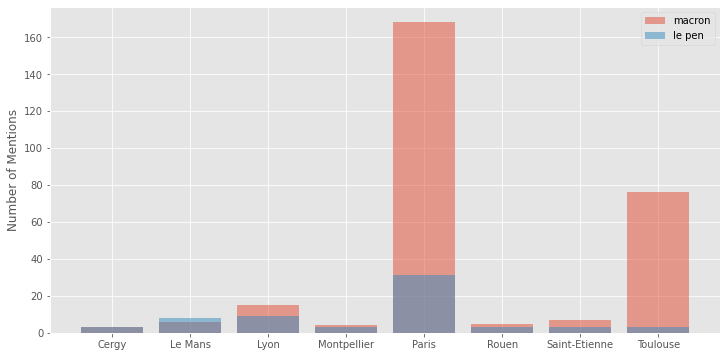

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(most_tweeted_cities['cities'], most_tweeted_cities['macrons'], label='macron', alpha=0.5);
ax.bar(most_tweeted_cities['cities'], most_tweeted_cities['le pens'], label='le pen', alpha=0.5);
ax.legend()
ax.set_ylabel("Number of Mentions");


## Shankar

In [15]:
query = '''SELECT user_id, followers, text
           FROM tweets
           ORDER BY followers DESC
            '''
df_new=spark.sql(query).toPandas()

In [16]:
df_new.head(10)

,user_id,followers,text
0,5520952,11782543,"Greve Geral é legitima, diz Ministerio Publico..."
1,5520952,11782383,Faith means believing the impossible - and the...
2,5520952,11781465,"@raullbenevides sim, fiz a letra e ajudei em g..."
3,5520952,11780912,Don't complain (you are not a victim). But hit...
4,52422878,5143423,Out of these four - my favorite Olympic Winte...
5,52422878,5139044,On this day April 26 Fanny Blankers-Koen was b...
6,32419107,3626961,@DelHazLou PARFAIT !!!! 🎉👏👏 #MonNomDeSuperstar...
7,32419107,3626943,Quel est votre nom de superstar #NRJ ??? Dîtes...
8,32419107,3626786,Sorry hein mais je crois que vos superstars on...
9,32419107,3626476,@_ClemTotaLmj Y'a moyen d'avoir des brochettes...


## Edward

Text(0, 0.5, 'Number of Tweets')

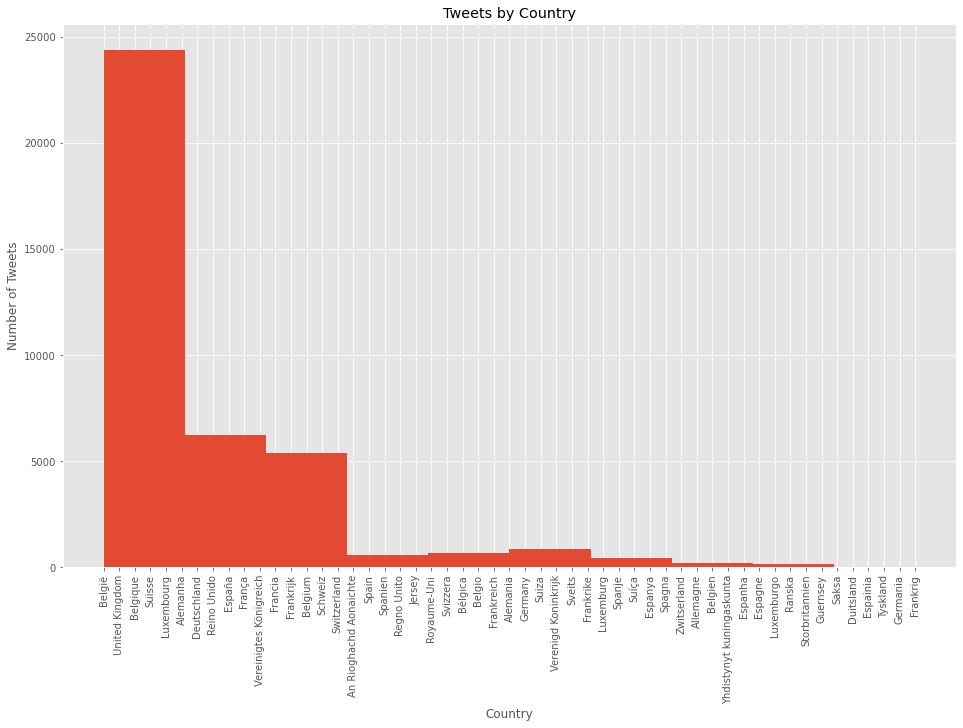

In [17]:
pd_df = df.tweets.toPandas()

fig, ax = plt.subplots(figsize=(16,10))
plt.xticks(rotation='vertical')
x = pd_df[pd_df['country'] != 'France']
ax.hist(x['country'])
ax.set_title("Tweets by Country")
ax.set_xlabel("Country")
ax.set_ylabel("Number of Tweets")